In [25]:
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

arxiv_api_wrapper = ArxivAPIWrapper(top_k_results=3,doc_content_chars_max=600)
wikipedia_api_wrapper = WikipediaAPIWrapper(top_k_results=3,doc_content_chars_max=600)

arxiv = ArxivQueryRun(api_wrapper=arxiv_api_wrapper)
wikipedia = WikipediaQueryRun(api_wrapper=wikipedia_api_wrapper)


In [26]:
import os
from dotenv import load_dotenv

load_dotenv()

# Do NOT print or hardcode API keys in the notebook. Ensure your .env file contains:

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

tavily.invoke({"query": "recent developments in AI field"})

[{'title': 'Top AI Trends 2025: Key Developments to Watch - Appinventiv',
  'url': 'https://appinventiv.com/blog/ai-trends/',
  'content': 'One of the most notable new developments in the AI field is the use of autonomous systems to make decisions for users. These AI agents are made',
  'score': 0.8080827},
 {'title': 'Advancements in AI and Machine Learning',
  'url': 'https://ep.jhu.edu/news/advancements-in-ai-and-machine-learning/',
  'content': 'The field of generative AI has seen remarkable progress, particularly with the development of advanced Large Language Models (LLMs). Meta’s recent release of Llama 4 includes models like Scout and Maverick that are designed to handle politically and socially contentious questions more effectively than their predecessors. They demonstrate reduced political bias and can process diverse data types, including text, video, images, and audio. \u200b [...] AI algorithms process vast datasets to provide insights that support strategic planning and 

In [57]:
#custom tools
def addition(State: dict) -> dict:
    """Function to add two numbers."""
    a = State['a']
    b = State['b']
    result = a + b
    return {'result': result}


def subtraction(State: dict):
    """Function to subtract two numbers."""
    a = State['a']
    b = State['b']
    result = a - b
    return {'result': result}


def multiplication(State: dict) -> dict:
    """Function to multiply two numbers."""
    a = State['a']
    b = State['b']
    result = a * b
    return {'result': result}

def division(State: dict) -> dict:
    """Function to divide two numbers."""
    a = State['a']
    b = State['b']
    if b == 0:
        return {'error': 'Division by zero is not allowed.'}
    result = a / b
    return {'result': result}


def current_weather(State: dict) -> dict:
    """Function to get the current weather of a city."""
    import requests

    city = State['city']
    try:
        url = f"https://wttr.in/{city}?format=3"
        response = requests.get(url)
        if response.status_code == 200:
            weather = response.text.strip()
            return {'weather': weather}
        else:
            return {'weather': f"Could not fetch weather for {city} (status code: {response.status_code})"}
    except Exception as e:
        return {'weather': f"Error fetching weather: {e}"}      


In [58]:
#tools

tools = [arxiv, wikipedia, tavily,multiplication, division, addition, subtraction, current_weather]

llm = ChatGroq(model="Gemma2-9b-It")

# Bind the tools to the LLM

llm_with_tools = llm.bind_tools(tools)

In [59]:
from langchain_core.messages import AnyMessage
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import tools_condition,ToolNode
from langgraph.graph.message import add_messages


from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages :Annotated[list[AnyMessage],add_messages]


In [60]:

def tool_function(State:State) -> dict:
    """    Function to invoke the LLM with tools and return the messages.
    Args:
        State (State): The state containing the messages.
    Returns:
        dict: A dictionary containing the messages after invoking the LLM with tools.

    """   
     # Invoke the LLM with tools and return the messages
    return {'messages':llm_with_tools.invoke(State['messages'])}

In [61]:

graph = StateGraph(State)

graph.add_node("tool_function",tool_function)
graph.add_node("tools",ToolNode(tools))


graph.add_edge(START,"tool_function")
graph.add_conditional_edges("tool_function",tools_condition)
graph.add_edge("tools","tool_function")




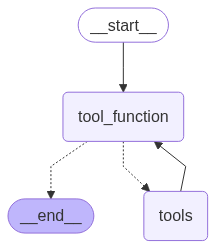

In [62]:
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import display,Image

memory = MemorySaver()


graph_builder = graph.compile(checkpointer=memory)

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [ ]:

from langchain_core.messages import HumanMessage

config = {"configurable":{"thread_id":"5"}}

messages=graph_builder.invoke({"messages": [HumanMessage(" tell me current temapertaure of kolkata")]},config=config)

In [70]:
for message in messages['messages']:
    message.pretty_print()  # Print the message content

================================ Human Message =================================

tell me about recent developments in AI field and then find out what is the weather of kolkata after that tell me about attention is all you need research paper
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (53b34rgy6)
 Call ID: 53b34rgy6
  Args:
    query: recent developments in AI field
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Top Stories in Recent AI News: Innovations and Updates", "url": "https://www.neudesic.com/blog/top-stories-ai-innovations/", "content": "Three remarkable breakthroughs stand out in recent AI research: Alibaba Cloud’s Qwen2-Math, Paige and Microsoft’s collaboration on cancer diagnosis, and SingularityNET’s decentralized supercomputer network for Artificial General Intelligence (AGI). Each of these developments showcases th